In [1]:
import numpy as np
import pandas as pd

# Assuming df is your original DataFrame
df = pd.read_excel(r'training model with all logs.xlsx')

In [31]:
df.head()


,RT,DEN,CNL,AC,GR,TOCmea,S1mea,S2mea
0,2.101,2.483,28.605,98.687,70.315,1.44,2.46,3.24
1,2.793,2.504,23.828,89.706,66.399,1.45,3.28,4.20
2,1.751,2.513,22.268,89.514,70.237,1.60,2.69,4.42
3,3.225,2.490,21.568,89.871,63.177,1.64,2.71,4.79
4,1.580,2.503,26.715,96.431,69.392,1.77,3.96,5.68


In [2]:
df.describe()

,RT,DEN,CNL,AC,GR,TOCmea,S1mea,S2mea
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,3.773320,2.454968,27.253936,100.059728,73.119920,3.430720,7.088960,12.620320
std,1.746204,0.060998,4.794873,11.476174,9.242313,1.658545,2.943881,7.578913
min,1.120000,2.284000,17.565000,78.492000,52.580000,1.440000,2.460000,3.240000
25%,2.461000,2.422000,23.637000,91.589000,66.310000,2.350000,4.790000,7.390000
50%,3.486000,2.462000,27.432000,99.456000,74.059000,2.890000,6.340000,10.060000
75%,4.640000,2.503000,30.203000,105.017000,79.847000,3.900000,8.920000,14.730000
max,9.299000,2.566000,38.228000,134.016000,94.045000,8.850000,17.940000,36.340000


In [3]:
df.corr()

,RT,DEN,CNL,AC,GR,TOCmea,S1mea,S2mea
RT,1.000000,-0.310926,0.104536,0.149240,-0.048547,0.615068,0.573705,0.611718
DEN,-0.310926,1.000000,-0.836608,-0.911378,-0.565657,-0.726897,-0.734330,-0.763170
CNL,0.104536,-0.836608,1.000000,0.918208,0.673465,0.588232,0.535665,0.644208
AC,0.149240,-0.911378,0.918208,1.000000,0.609294,0.709943,0.639788,0.742202
GR,-0.048547,-0.565657,0.673465,0.609294,1.000000,0.251211,0.257407,0.286244
TOCmea,0.615068,-0.726897,0.588232,0.709943,0.251211,1.000000,0.849372,0.983431
S1mea,0.573705,-0.734330,0.535665,0.639788,0.257407,0.849372,1.000000,0.869001
S2mea,0.611718,-0.763170,0.644208,0.742202,0.286244,0.983431,0.869001,1.000000


In [38]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from copulas.multivariate import GaussianMultivariate

# Step 1: Check skewness
def check_skewness(data):
    skewness = data.skew()
    print("Skewness of Columns:\n", skewness)

# Step 2: Apply transformations to skewed data
def transform_skewed_columns(df):
    transformed_data = df.copy()
    for col in df.columns:
        if skew(df[col]) > 1:  # Right-skewed
            transformed_data[col] = np.log1p(df[col] - df[col].min() + 1)
        elif skew(df[col]) < -1:  # Left-skewed
            transformed_data[col] = np.log1p(df[col].max() - df[col] + 1)
    return transformed_data

# Step 3: Fit Gaussian copula for synthetic data generation
def augment_data_with_copula(original_df, num_samples):
    # Fit the copula
    copula = GaussianMultivariate()
    copula.fit(original_df)

    # Generate synthetic data
    synthetic_data = copula.sample(num_samples)

    # Convert synthetic data to DataFrame
    synthetic_df = pd.DataFrame(synthetic_data, columns=original_df.columns)

    # Combine original and synthetic data
    augmented_df = pd.concat([original_df, synthetic_df], ignore_index=True)
    return augmented_df


check_skewness(df)


transformed_df = transform_skewed_columns(df)


num_new_samples = 375  # Number of synthetic samples to generate
augmented_df = augment_data_with_copula(transformed_df, num_new_samples)

# Invert transformations (if applied)
def invert_transformations(augmented_df, original_df):
    for col in original_df.columns:
        if skew(original_df[col]) > 1:  # Right-skewed
            augmented_df[col] = np.expm1(augmented_df[col]) + original_df[col].min() - 1
        elif skew(original_df[col]) < -1:  # Left-skewed
            augmented_df[col] = original_df[col].max() - np.expm1(augmented_df[col]) + 1
    return augmented_df

final_augmented_df = invert_transformations(augmented_df, df)

# Save and validate the augmented dataset
final_augmented_df.to_csv('augmented_data_with_skewness.csv', index=False)

# Display validation results
print("Augmented Data Statistics:\n", final_augmented_df.describe())
print("Augmented Data Correlation Matrix:\n", final_augmented_df.corr())



Skewness of Columns:
 RT        0.999054
DEN      -0.801132
CNL       0.094889
AC        0.713349
GR       -0.164279
TOCmea    1.606907
S1mea     1.096128
S2mea     1.521932
dtype: float64


c:\Users\Asus\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Asus\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Asus\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Asus\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Asus\anaconda3\Lib\site-packages\scipy\stats\_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Augmented Data Statistics:
                RT         DEN         CNL          AC          GR      TOCmea  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     3.878128    2.453973   27.084321   99.828796   72.577282    3.439307   
std      1.683983    0.062410    5.054168   12.290919    9.686074    1.620790   
min      1.120000    2.256877   14.304961   71.445603   46.033014    1.440000   
25%      2.507642    2.420924   23.246660   91.579652   65.600178    2.321054   
50%      3.588325    2.462903   27.072427   98.830830   73.015115    2.930770   
75%      5.007497    2.501307   30.325978  105.656764   79.251091    4.012466   
max      9.299000    2.572848   42.350830  138.313231   96.691019   12.003114   

            S1mea       S2mea  
count  500.000000  500.000000  
mean     7.155101   12.929373  
std      2.932008    7.950970  
min      2.196340    3.146174  
25%      4.939229    7.292660  
50%      6.598035   10.040097  
75%      8.895297 

In [39]:
final_augmented_df.corr()

,RT,DEN,CNL,AC,GR,TOCmea,S1mea,S2mea
RT,1.000000,-0.244400,0.063049,0.088731,-0.017792,0.514195,0.537227,0.513812
DEN,-0.244400,1.000000,-0.820727,-0.887473,-0.598068,-0.566751,-0.634464,-0.605834
CNL,0.063049,-0.820727,1.000000,0.919411,0.663230,0.482039,0.469668,0.525761
AC,0.088731,-0.887473,0.919411,1.000000,0.624051,0.537786,0.534783,0.571626
GR,-0.017792,-0.598068,0.663230,0.624051,1.000000,0.250011,0.283006,0.258978
TOCmea,0.514195,-0.566751,0.482039,0.537786,0.250011,1.000000,0.825811,0.961764
S1mea,0.537227,-0.634464,0.469668,0.534783,0.283006,0.825811,1.000000,0.858392
S2mea,0.513812,-0.605834,0.525761,0.571626,0.258978,0.961764,0.858392,1.000000


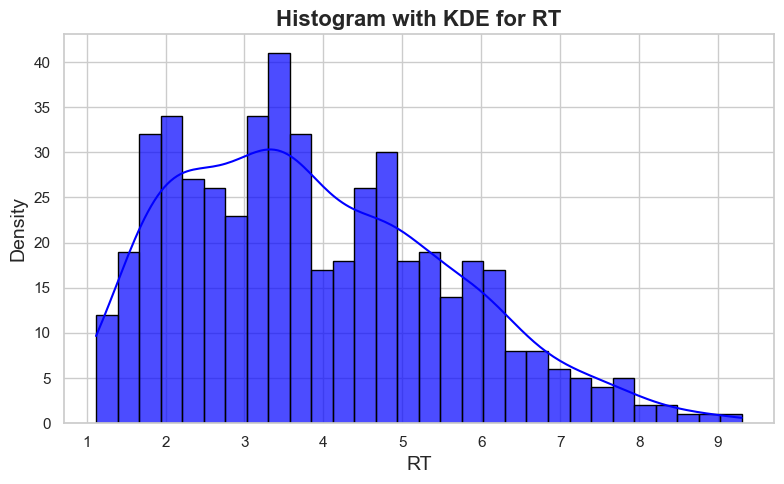

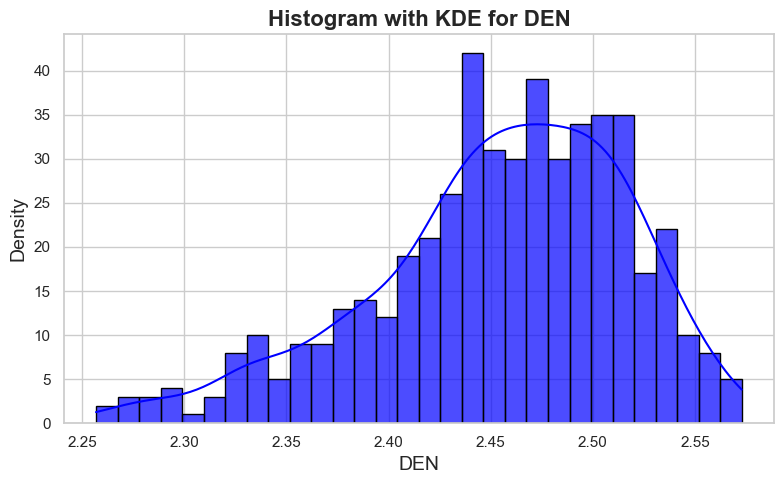

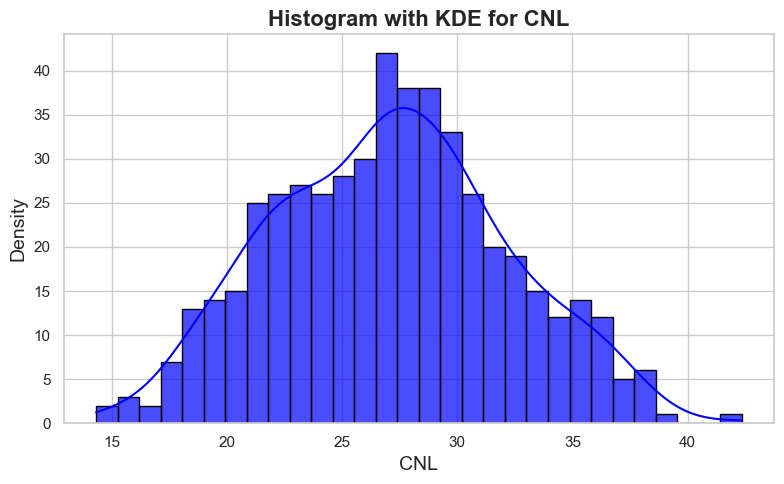

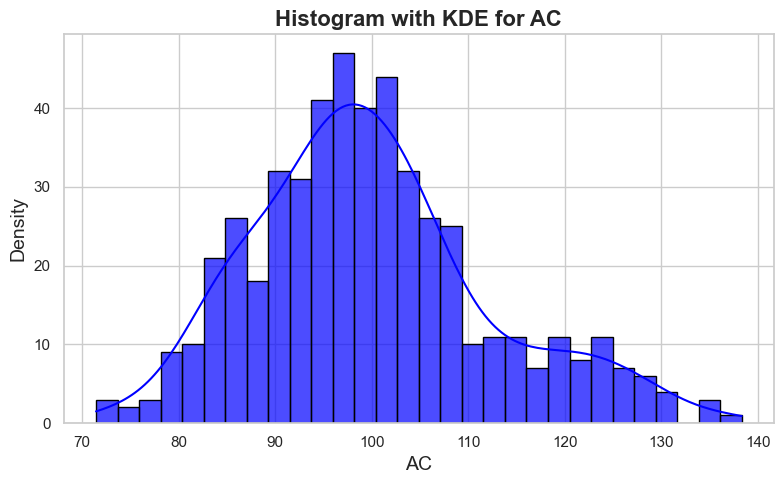

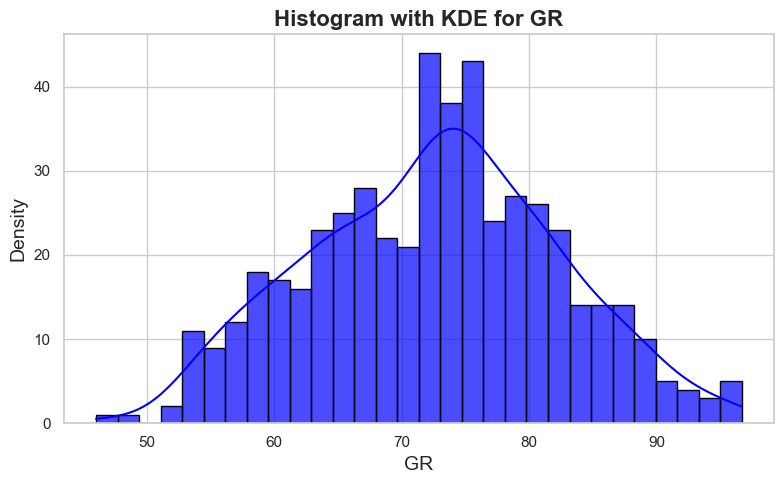

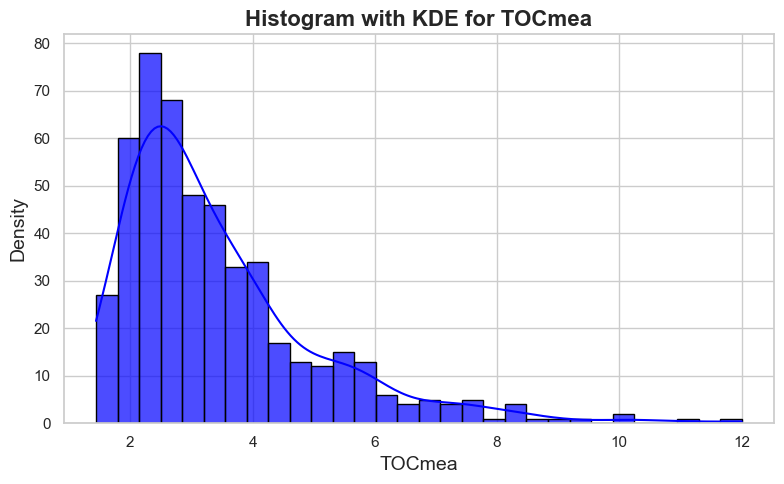

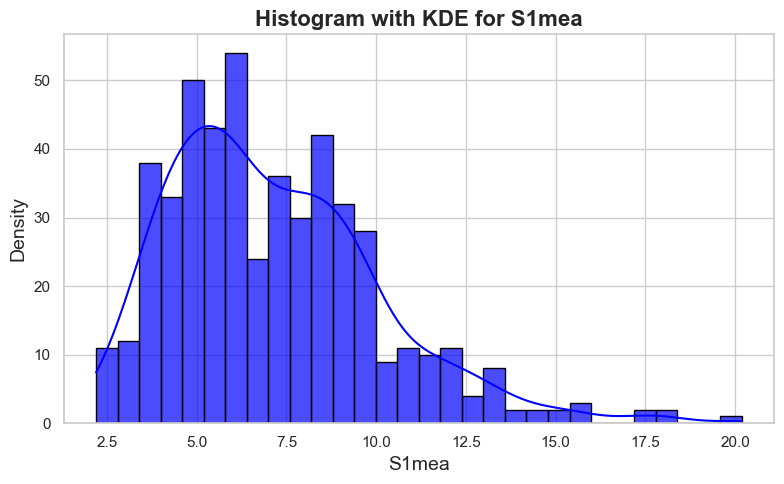

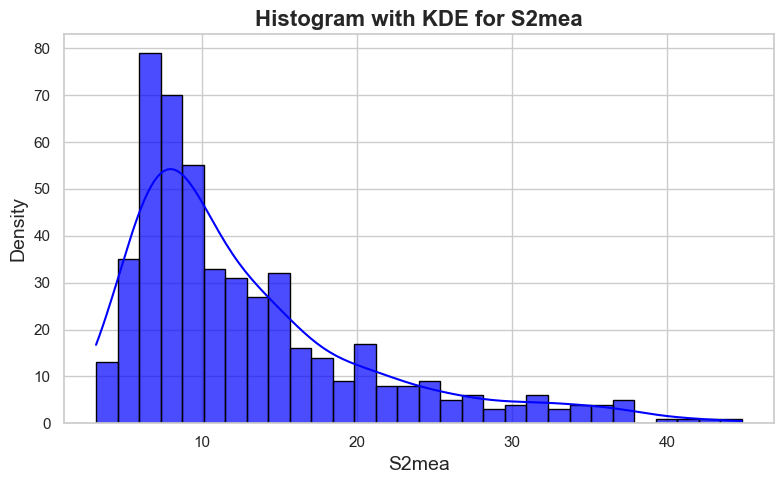

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called `df`
columns = ['RT', 'DEN', 'CNL', 'AC', 'GR', 'TOCmea', 'S1mea', 'S2mea']

# Set a style for the plots
sns.set(style="whitegrid")

# Plot histograms with KDE for each column
for column in columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(final_augmented_df[column], kde=True, bins=30, color="blue", edgecolor="black", alpha=0.7)
    plt.title(f'Histogram with KDE for {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{column}_hist_kde.png')  # Save the plot
    plt.show()


In [ ]:
df.describe()

In [ ]:
augmented_df.describe()

In [ ]:
augmented_df.corr()


In [ ]:
df.corr()

In [ ]:
import numpy as np
import pandas as pd

# Assuming your original data is in a DataFrame called `df`
# First, get the mean and covariance matrix
mean_vector = df.mean().values
cov_matrix = df.cov().values

# Define the number of additional rows to generate
num_new_samples = 375  # To make the total number of rows 500

# Generate synthetic data using multivariate normal distribution
synthetic_data = np.random.multivariate_normal(mean_vector, cov_matrix, num_new_samples)

# Create a DataFrame with the generated data
columns = df.columns  # Assuming you have the same columns
synthetic_df = pd.DataFrame(synthetic_data, columns=columns)

# Combine the original data with the synthetic data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

# Check the augmented data statistics
print(augmented_df.describe())

# Check the correlation matrix of the augmented data
print(augmented_df.corr())

# Optional: Save the augmented data to a CSV file
augmented_df.to_csv('augmented_data.csv', index=False)

# Display the first few rows of the augmented data
print(augmented_df.head())


In [4]:
from scipy.stats import multivariate_normal

# Fit a multivariate normal distribution to your data
mean = df.mean(axis=0)
cov = df.cov()

In [ ]:
cov 

In [18]:
from scipy.stats import multivariate_normal

# Fit a multivariate normal distribution to your data
mean = df.mean(axis=0)
cov = df.cov()

# Sample new data from the fitted distribution
num_samples = 500 - len(df)
mv_normal = multivariate_normal(mean=mean, cov=cov)

# Generate synthetic data
synthetic_data = mv_normal.rvs(size=num_samples)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# Concatenate the original and synthetic data
augmented_df_1 = pd.concat([df, synthetic_df], ignore_index=True)


In [19]:
augmented_df_1.to_csv('ad_mvnd.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add a 'Source' column to indicate the origin of the data
augmented_df_1['Source'] = ['Original'] * len(df) + ['Synthetic'] * len(synthetic_df)

# Get the name of the last column
last_column = df.columns[-3]

# Loop through all columns except the last one and plot them against the last column
for col in df.columns[:-3]:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of each column vs the last column using Seaborn's scatterplot
    sns.scatterplot(x=augmented_df_1[augmented_df_1['Source'] == 'Original'][col], 
                    y=augmented_df_1[augmented_df_1['Source'] == 'Original'][last_column], 
                    color='blue', alpha=0.6, label='Original', marker='o')
    
    sns.scatterplot(x=augmented_df_1[augmented_df_1['Source'] == 'Synthetic'][col], 
                    y=augmented_df_1[augmented_df_1['Source'] == 'Synthetic'][last_column], 
                    color='orange', alpha=0.6, label='Synthetic', marker='s')
    
    plt.xlabel(col)
    plt.ylabel(last_column)
    plt.title(f'Comparison of Original and Synthetic Data: {col} vs {last_column}')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d

# Load your original dataset (assuming you have a CSV file or DataFrame)
# df = pd.read_csv("your_data.csv")  # Or use df if it's already in memory


copula = GaussianMultivariate()  # Gaussian copula
copula.fit(df)  # Fit copula to the data

# Generate synthetic data (2000 rows in this case)
num_samples = 600 - len(df)
synthetic_data = copula.sample(num_samples)

# Convert the synthetic data into a DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# Combine the original data with the synthetic data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)



In [11]:
augmented_df.to_csv('adcopla_fd.csv')

In [ ]:
df.corr()

In [ ]:
augmented_df.corr()

In [ ]:
df1.corr()

In [16]:
df1=pd.read_csv('ad_mvnd.csv')

In [ ]:
import matplotlib.pyplot as plt

# Add a column to indicate the source of the data
augmented_df['Source'] = ['Original'] * len(df) + ['Synthetic'] * len(synthetic_df)

# Get the name of the last column
last_column = df.columns[-1]

# Loop through all columns except the last one and plot them against the last column
for col in df.columns[:-1]:
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for each column vs the last column
    plt.scatter(augmented_df[augmented_df['Source'] == 'Original'][col], 
                augmented_df[augmented_df['Source'] == 'Original'][last_column], 
                color='blue', alpha=0.6, label='Original')

    plt.scatter(augmented_df[augmented_df['Source'] == 'Synthetic'][col], 
                augmented_df[augmented_df['Source'] == 'Synthetic'][last_column], 
                color='orange', alpha=0.6, label='Synthetic')

    plt.xlabel(col)
    plt.ylabel(last_column)
    plt.title(f'Comparison of Original and Synthetic Data: {col} vs {last_column}')
    plt.legend()
    plt.show()


In [ ]:
pip install --upgrade copulas


In [ ]:
import pandas as pd
import numpy as np
from copulas.univariate import KDEUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import scatter_2d

# Load your original dataset (assuming you have a CSV file or DataFrame)
df = pd.read_csv("training model with all logs.csv")  # Or use df if it's already in memory

# Define KDE for each column to handle original distributions
marginals = {}
for column in df.columns:
    kde = KDEUnivariate()
    kde.fit(df[column])
    marginals[column] = kde

# Transform original data to uniform marginals
transformed_data = np.column_stack(
    [marginals[col].to_uniform(df[col]) for col in df.columns]
)

# Fit the Gaussian copula to the transformed data
copula = GaussianMultivariate()
copula.fit(transformed_data)

# Generate synthetic data (2000 rows in this case)
num_samples = 600 - len(df)
synthetic_data = copula.sample(num_samples)

# Back-transform synthetic data to the original distribution
synthetic_data_original = pd.DataFrame({
    col: marginals[col].from_uniform(synthetic_data[:, idx])
    for idx, col in enumerate(df.columns)
})

# Combine the original data with the synthetic data
augmented_df = pd.concat([df, synthetic_data_original], ignore_index=True)

# Save or use the augmented data
augmented_df.to_csv("augmented_data_od.csv", index=False)


In [9]:

# Load your original dataset (assuming you have a CSV file or DataFrame)
df = pd.read_csv("training model with all logs.csv")  # Or use df if it's already in memory

In [ ]:
augmented_df.corr()